In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from pathlib import Path

from opera_tropo import download

In [3]:
# Requires doing aws-login before
hres_sds = download.HRESDownloader()
# Check the number of files in s3 bucket
hres_dates = hres_sds.list_matching_keys(start_date='20240101',
                                         end_date='20250101')

hres_dates = pd.DataFrame(hres_dates, columns=['s3_key', 'url'])
hres_dates['dates'] = hres_dates['s3_key'].apply(lambda x: x.split('/')[0])
hres_dates['filename'] = hres_dates['s3_key'].apply(lambda x: x.split('/')[1])
hres_dates = hres_dates[['dates', 'filename', 's3_key', 'url']]
hres_dates

,dates,filename,s3_key,url
0,20240101,ECMWF_TROP_202401010000_202401010000_1.nc,20240101/ECMWF_TROP_202401010000_202401010000_...,s3://opera-ecmwf/20240101/ECMWF_TROP_202401010...
1,20240101,ECMWF_TROP_202401010600_202401010600_1.nc,20240101/ECMWF_TROP_202401010600_202401010600_...,s3://opera-ecmwf/20240101/ECMWF_TROP_202401010...
2,20240101,ECMWF_TROP_202401011200_202401011200_1.nc,20240101/ECMWF_TROP_202401011200_202401011200_...,s3://opera-ecmwf/20240101/ECMWF_TROP_202401011...
3,20240101,ECMWF_TROP_202401011800_202401011800_1.nc,20240101/ECMWF_TROP_202401011800_202401011800_...,s3://opera-ecmwf/20240101/ECMWF_TROP_202401011...
4,20240102,ECMWF_TROP_202401020000_202401020000_1.nc,20240102/ECMWF_TROP_202401020000_202401020000_...,s3://opera-ecmwf/20240102/ECMWF_TROP_202401020...
...,...,...,...,...
1459,20241230,ECMWF_TROP_202412301800_202412301800_1.nc,20241230/ECMWF_TROP_202412301800_202412301800_...,s3://opera-ecmwf/20241230/ECMWF_TROP_202412301...
1460,20241231,ECMWF_TROP_202412310000_202412310000_1.nc,20241231/ECMWF_TROP_202412310000_202412310000_...,s3://opera-ecmwf/20241231/ECMWF_TROP_202412310...
1461,20241231,ECMWF_TROP_202412310600_202412310600_1.nc,20241231/ECMWF_TROP_202412310600_202412310600_...,s3://opera-ecmwf/20241231/ECMWF_TROP_202412310...
1462,20241231,ECMWF_TROP_202412311200_202412311200_1.nc,20241231/ECMWF_TROP_202412311200_202412311200_...,s3://opera-ecmwf/20241231/ECMWF_TROP_202412311...


In [ ]:
import boto3
from botocore.exceptions import ClientError

session = boto3.Session(profile_name='saml-pub')
s3 = session.client('s3')

try:
    s3.head_object(Bucket='opera-ecmwf', Key='20250318/ECMWF_TROP_202503180600_202503180600_1.nc')
    print("Access OK")
except ClientError as e:
    error_code = e.response['Error']['Code']
    if error_code == '404':
        print("File not found")
    elif error_code == '403':
        print("Access denied - check permissions")
    else:
        print(f"Access error: {e}")

Access OK


In [7]:
hres_dates.iloc[0].url

's3://opera-ecmwf/20240101/ECMWF_TROP_202401010000_202401010000_1.nc'

In [8]:
import xarray as xr
import s3fs
fs = s3fs.S3FileSystem(profile='saml-pub')
with fs.open(hres_dates.iloc[0].url) as f:
    ds = xr.open_dataset(f, engine='h5netcdf', chunks={})
    #min_temp = ds.t.load().min().item()
    #max_temp = ds.t.load().max().item()
    #print(f"Minimum temperature: {min_temp}")
    #print(f"Maximum temperature: {max_temp}")
    da = ds.z.isel(time=0, level=0).load()

In [9]:
list(ds.chunksizes.items())

[('time', (1,)),
 ('level', (28, 28, 28, 28, 25)),
 ('latitude', (512, 512, 512, 512, 512)),
 ('longitude', (1024, 1024, 1024, 1024, 1024))]

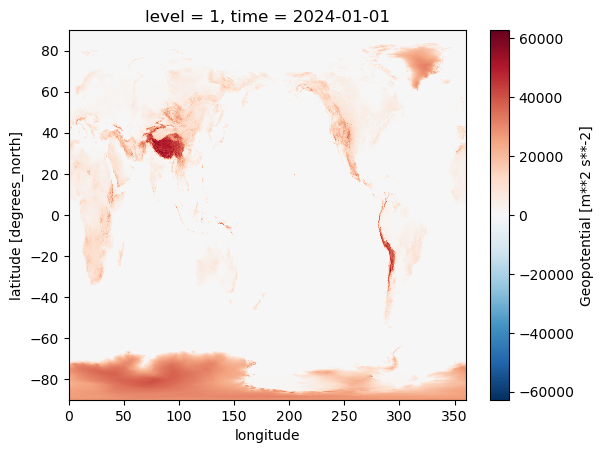

In [24]:
da.plot.imshow()

In [10]:
print(hres_dates.iloc[1].url)

s3://opera-ecmwf/20240101/ECMWF_TROP_202401010600_202401010600_1.nc


In [11]:
import pandas as pd
from dask.distributed import Client
import dask
import numpy as np
import xarray as xr
import s3fs
from datetime import datetime
import os
from pathlib import Path
from typing import Dict, List, Tuple, Optional, Any
import logging


class WeatherDataAnalyzer:
    """
    A class for analyzing weather data from NetCDF files and generating statistical reports.
    """
    
    def __init__(self, output_dir: str = './weather_stats', n_workers: int = 4, 
                 s3_profile: str = 'saml-pub', verbose: bool = True):
        """
        Initialize the WeatherDataAnalyzer.
        
        Parameters:
        -----------
        output_dir : str
            Directory to save output files
        n_workers : int
            Number of Dask workers
        s3_profile : str
            S3 profile name for authentication
        verbose : bool
            Whether to print progress messages
        """
        self.output_dir = Path(output_dir)
        self.n_workers = n_workers
        self.s3_profile = s3_profile
        self.verbose = verbose
        self.logger = self._setup_logging()
        
        # Variable configurations
        self.variable_configs = {
            'z': {'levels': [0], 'desc': 'Geopotential (surface)', 'check_negative': False},
            't': {'levels': 'all', 'desc': 'Temperature (all levels)', 'check_negative': False},
            'q': {'levels': 'all', 'desc': 'Specific humidity (all levels)', 'check_negative': True},
            'lnsp': {'levels': [0], 'desc': 'Log surface pressure', 'check_negative': False}
        }
    
    def _setup_logging(self) -> logging.Logger:
        """Set up logging configuration."""
        logger = logging.getLogger(__name__)
        if not logger.handlers:
            handler = logging.StreamHandler()
            formatter = logging.Formatter('%(asctime)s - %(levelname)s - %(message)s')
            handler.setFormatter(formatter)
            logger.addHandler(handler)
            logger.setLevel(logging.INFO if self.verbose else logging.WARNING)
        return logger
    
    def _print(self, *args, **kwargs):
        """Print function that respects verbose setting."""
        if self.verbose:
            print(*args, **kwargs)
    
    def _extract_time_info(self, dataset: xr.Dataset) -> Tuple[str, str]:
        """
        Extract model date and time information from dataset.
        
        Parameters:
        -----------
        dataset : xr.Dataset
            The xarray dataset
            
        Returns:
        --------
        Tuple[str, str]
            Model date string and model time string
        """
        try:
            if 'time' in dataset.coords:
                model_time = pd.to_datetime(dataset.time.values[0])
                return (model_time.strftime('%Y-%m-%d'), 
                       model_time.strftime('%H:%M:%S UTC'))
            else:
                self.logger.warning("No time coordinate found in dataset")
                return "Unknown", "Unknown"
        except Exception as e:
            self.logger.warning(f"Error extracting time info: {e}")
            return "Unknown", "Unknown"
    
    def _get_variable_data(self, dataset: xr.Dataset, var: str, config: Dict[str, Any]) -> Optional[xr.DataArray]:
        """
        Extract variable data based on configuration.
        
        Parameters:
        -----------
        dataset : xr.Dataset
            The xarray dataset
        var : str
            Variable name
        config : Dict[str, Any]
            Variable configuration
            
        Returns:
        --------
        Optional[xr.DataArray]
            The extracted data array or None if variable not found
        """
        if var not in dataset.data_vars:
            self.logger.warning(f"Variable '{var}' not found in dataset")
            return None
            
        data = dataset[var]
        
        # Apply level selection if specified
        if config['levels'] != 'all' and 'level' in data.dims:
            try:
                data = data.isel(level=config['levels'])
            except (IndexError, KeyError) as e:
                self.logger.warning(f"Error selecting levels for {var}: {e}")
                
        return data
    
    def _compute_statistics(self, data: xr.DataArray, var: str, config: Dict[str, Any]) -> Dict[str, Any]:
        """
        Compute comprehensive statistics for a variable.
        
        Parameters:
        -----------
        data : xr.DataArray
            The data array to analyze
        var : str
            Variable name
        config : Dict[str, Any]
            Variable configuration
            
        Returns:
        --------
        Dict[str, Any]
            Dictionary of computed statistics
        """
        stats = {
            f'{var}_min': data.min(),
            f'{var}_max': data.max(),
            f'{var}_mean': data.mean(),
            f'{var}_std': data.std(),
            f'{var}_total_size': data.size,
            f'{var}_nan_count': data.isnull().sum(),
            f'{var}_zero_count': (data == 0.0).sum(),
            f'{var}_inf_count': np.isinf(data).sum(),
            f'{var}_finite_count': np.isfinite(data).sum()
        }
        
        # Add negative count only for variables where it's relevant
        if config['check_negative']:
            stats[f'{var}_negative_count'] = (data < 0).sum()
        else:
            # Use xarray/dask array with value 0 to maintain consistency
            stats[f'{var}_negative_count'] = xr.DataArray(0)
            
        return stats
    
    def _create_quality_flags(self, var: str, results: Dict[str, Any], config: Dict[str, Any]) -> List[str]:
        """
        Create quality flags based on computed statistics.
        
        Parameters:
        -----------
        var : str
            Variable name
        results : Dict[str, Any]
            Computed statistics
        config : Dict[str, Any]
            Variable configuration
            
        Returns:
        --------
        List[str]
            List of quality flag strings
        """
        flags = []
        
        nan_count = results[f'{var}_nan_count'].item()
        inf_count = results[f'{var}_inf_count'].item()
        zero_count = results[f'{var}_zero_count'].item()
        negative_count = results[f'{var}_negative_count'].item()
        
        if nan_count > 0:
            flags.append(f"NaN({nan_count})")
        if inf_count > 0:
            flags.append(f"Inf({inf_count})")
        if zero_count > 0:
            flags.append(f"Zero({zero_count})")
        if negative_count > 0 and config['check_negative']:
            flags.append(f"Neg({negative_count})")
            
        return flags
    
    def _create_summary_dataframe(self, all_results: Dict[str, Any]) -> pd.DataFrame:
        """
        Create summary DataFrame from computed results.
        
        Parameters:
        -----------
        all_results : Dict[str, Any]
            All computed statistics
            
        Returns:
        --------
        pd.DataFrame
            Summary DataFrame
        """
        summary_data = []
        
        for var, config in self.variable_configs.items():
            if f'{var}_min' not in all_results:
                continue
                
            total_size = all_results[f'{var}_total_size']
            nan_count = all_results[f'{var}_nan_count'].item()
            zero_count = all_results[f'{var}_zero_count'].item()
            negative_count = all_results[f'{var}_negative_count'].item()
            inf_count = all_results[f'{var}_inf_count'].item()
            finite_count = all_results[f'{var}_finite_count'].item()
            
            quality_flags = self._create_quality_flags(var, all_results, config)
            
            summary_data.append({
                'Variable': var,
                'Description': config['desc'],
                'Min': all_results[f'{var}_min'].item(),
                'Max': all_results[f'{var}_max'].item(),
                'Mean': all_results[f'{var}_mean'].item(),
                'Std': all_results[f'{var}_std'].item(),
                'Total_Size': total_size,
                'Finite_Count': finite_count,
                'NaN_Count': nan_count,
                'Inf_Count': inf_count,
                'Zero_Count': zero_count,
                'Negative_Count': negative_count,
                'NaN_%': f"{nan_count/total_size*100:.3f}%",
                'Zero_%': f"{zero_count/total_size*100:.3f}%",
                'Completeness_%': f"{finite_count/total_size*100:.2f}%",
                'Data_Quality': '; '.join(quality_flags) if quality_flags else 'OK'
            })
        
        return pd.DataFrame(summary_data)
    
    def _generate_report_header(self, file_url: str, model_date_str: str, 
                               model_time_str: str, dataset: xr.Dataset) -> str:
        """Generate comprehensive report header."""
        return f"""
{'='*80}
WEATHER DATA STATISTICAL ANALYSIS REPORT
{'='*80}
Analysis Timestamp: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}
Source File: {file_url}
Model Date: {model_date_str}
Model Time: {model_time_str}

Dataset Information:
- Dimensions: {dict(dataset.sizes)}
- Coordinates: {list(dataset.coords.keys())}
- Data Variables: {list(dataset.data_vars.keys())}
- Global Attributes: {len(dataset.attrs)} attributes

Variable Processing Configuration:
{self._format_variable_configs()}
{'='*80}

STATISTICAL SUMMARY:
"""
    
    def _format_variable_configs(self) -> str:
        """Format variable configurations for display."""
        config_lines = []
        for var, config in self.variable_configs.items():
            levels_str = "all levels" if config['levels'] == 'all' else f"levels {config['levels']}"
            config_lines.append(f"- {var}: {levels_str}")
        return '\n'.join(config_lines)
    
    def _export_results(self, summary_df: pd.DataFrame, file_url: str, 
                       model_date_str: str, model_time_str: str, 
                       dataset: xr.Dataset) -> Tuple[str, str]:
        """
        Export results to text and CSV files.
        
        Returns:
        --------
        Tuple[str, str]
            Paths to text and CSV files
        """
        # Generate output filenames
        analysis_timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
        date_part = model_date_str.replace('-', '') if model_date_str != "Unknown" else "unknown"
        
        try:
            hour_part = pd.to_datetime(f"{model_date_str} {model_time_str}").strftime("%H")
        except:
            hour_part = "unknown"
            
        base_filename = f"weather_stats_{date_part}_{hour_part}_{analysis_timestamp}"
        
        txt_path = self.output_dir / f"{base_filename}.txt"
        csv_path = self.output_dir / f"{base_filename}.csv"
        
        # Export text report
        self._export_text_report(txt_path, summary_df, file_url, model_date_str, model_time_str, dataset)
        
        # Export CSV
        self._export_csv_report(csv_path, summary_df, file_url, model_date_str, model_time_str, analysis_timestamp)
        
        return str(txt_path), str(csv_path)
    
    def _export_text_report(self, file_path: Path, summary_df: pd.DataFrame, 
                           file_url: str, model_date_str: str, model_time_str: str, 
                           dataset: xr.Dataset):
        """Export detailed text report."""
        header = self._generate_report_header(file_url, model_date_str, model_time_str, dataset)
        
        with open(file_path, 'w') as f:
            f.write(header)
            
            # Write summary table
            f.write("\nDETAILED STATISTICS TABLE:\n")
            f.write("=" * 140 + "\n")
            
            # Format DataFrame for better text output
            display_df = summary_df.copy()
            numerical_cols = ['Min', 'Max', 'Mean', 'Std']
            for col in numerical_cols:
                display_df[col] = display_df[col].round(6)
            
            f.write(display_df.to_string(index=False, max_colwidth=30))
            
            # Write data quality summary
            self._write_quality_summary(f, summary_df)
            
            # Write detailed variable information
            self._write_detailed_info(f, summary_df)
    
    def _export_csv_report(self, file_path: Path, summary_df: pd.DataFrame, 
                          file_url: str, model_date_str: str, model_time_str: str, 
                          analysis_timestamp: str):
        """Export CSV report with metadata."""
        csv_df = summary_df.copy()
        csv_df.insert(0, 'Source_File', file_url)
        csv_df.insert(1, 'Model_Date', model_date_str)
        csv_df.insert(2, 'Model_Time', model_time_str)
        csv_df.insert(3, 'Analysis_Timestamp', analysis_timestamp)
        
        csv_df.to_csv(file_path, index=False)
    
    def _write_quality_summary(self, file_handle, summary_df: pd.DataFrame):
        """Write data quality summary section."""
        file_handle.write(f"\n\n{'='*50}\n")
        file_handle.write("DATA QUALITY SUMMARY:\n")
        file_handle.write(f"{'='*50}\n")
        
        for _, row in summary_df.iterrows():
            status = "✅ No issues detected" if row['Data_Quality'] == 'OK' else row['Data_Quality']
            file_handle.write(f"{row['Variable']}: {status}\n")
    
    def _write_detailed_info(self, file_handle, summary_df: pd.DataFrame):
        """Write detailed variable information section."""
        file_handle.write(f"\n{'='*50}\n")
        file_handle.write("DETAILED VARIABLE INFORMATION:\n")
        file_handle.write(f"{'='*50}\n")
        
        for _, row in summary_df.iterrows():
            file_handle.write(f"\n{row['Variable'].upper()} - {row['Description']}:\n")
            file_handle.write(f"  Range: [{row['Min']:.6f}, {row['Max']:.6f}]\n")
            file_handle.write(f"  Mean ± Std: {row['Mean']:.6f} ± {row['Std']:.6f}\n")
            file_handle.write(f"  Data completeness: {row['Finite_Count']:,}/{row['Total_Size']:,} ({row['Completeness_%']})\n")
            
            if row['NaN_Count'] > 0:
                file_handle.write(f"  Missing values: {row['NaN_Count']:,} ({row['NaN_%']})\n")
            if row['Zero_Count'] > 0:
                file_handle.write(f"  Zero values: {row['Zero_Count']:,} ({row['Zero_%']})\n")
            if row['Inf_Count'] > 0:
                file_handle.write(f"  Infinite values: {row['Inf_Count']:,}\n")
    
    def analyze_file(self, hres_dates: pd.DataFrame, file_index: int = 0) -> Tuple[pd.DataFrame, str, str]:
        """
        Analyze a weather data file and export statistics.
        
        Parameters:
        -----------
        hres_dates : pd.DataFrame
            DataFrame containing URLs and metadata for weather files
        file_index : int
            Index of the file to analyze from hres_dates
            
        Returns:
        --------
        Tuple[pd.DataFrame, str, str]
            Summary DataFrame, text report path, and CSV report path
        """
        # Create output directory
        self.output_dir.mkdir(parents=True, exist_ok=True)
        
        if file_index >= len(hres_dates):
            raise IndexError(f"File index {file_index} is out of range (0-{len(hres_dates)-1})")
        
        file_url = hres_dates.iloc[file_index].url
        self.logger.info(f"Processing: {file_url}")
        
        try:
            with Client(n_workers=self.n_workers, threads_per_worker=2) as client:
                # Initialize S3 filesystem
                fs = s3fs.S3FileSystem(
                    profile=self.s3_profile,
                    config_kwargs={'max_pool_connections': 50}
                )
                
                # Open dataset
                with fs.open(file_url, mode='rb') as f:
                    dataset = xr.open_dataset(f, engine='h5netcdf', chunks='auto')
                
                # Extract time information
                model_date_str, model_time_str = self._extract_time_info(dataset)
                
                # Compute statistics for all variables
                all_operations = {}
                processed_vars = []
                
                for var, config in self.variable_configs.items():
                    data = self._get_variable_data(dataset, var, config)
                    if data is not None:
                        stats = self._compute_statistics(data, var, config)
                        all_operations.update(stats)
                        processed_vars.append(var)
                
                if not all_operations:
                    raise ValueError("No valid variables found in dataset")
                
                self.logger.info("Computing statistics...")
                results = dask.compute(all_operations)[0]
                
                # Create summary DataFrame
                summary_df = self._create_summary_dataframe(results)
                
                # Export results
                txt_path, csv_path = self._export_results(
                    summary_df, file_url, model_date_str, model_time_str, dataset
                )
                
                # Display results
                if self.verbose:
                    self._display_results(summary_df, txt_path, csv_path)
                
                self.logger.info(f"Analysis completed successfully")
                self.logger.info(f"Text report: {txt_path}")
                self.logger.info(f"CSV report: {csv_path}")
                
                return summary_df, txt_path, csv_path
                
        except Exception as e:
            self.logger.error(f"Error during analysis: {e}")
            raise
    
    def _display_results(self, summary_df: pd.DataFrame, txt_path: str, csv_path: str):
        """Display results to console."""
        pd.set_option('display.max_columns', None)
        pd.set_option('display.width', None)
        
        print("\n" + "="*80)
        print("ANALYSIS RESULTS SUMMARY")
        print("="*80)
        print(summary_df.round(6))
        
        print(f"\n{'='*50}")
        print("DATA QUALITY SUMMARY:")
        print(f"{'='*50}")
        
        for _, row in summary_df.iterrows():
            status = "✅ No issues detected" if row['Data_Quality'] == 'OK' else row['Data_Quality']
            print(f"{row['Variable']}: {status}")
        
        print(f"\n Results exported to:")
        print(f"   Text report: {txt_path}")
        print(f"   CSV data: {csv_path}")


# Convenience function for backward compatibility
def analyze_and_export_weather_data(hres_dates: pd.DataFrame, file_index: int = 0, 
                                  output_dir: str = './weather_stats', n_workers: int = 4, 
                                  show: bool = True) -> Tuple[pd.DataFrame, str, str]:
    """
    Legacy function for backward compatibility.
    
    Parameters:
    -----------
    hres_dates : pd.DataFrame
        DataFrame containing URLs and metadata for weather files
    file_index : int
        Index of the file to analyze from hres_dates
    output_dir : str
        Directory to save output files
    n_workers : int
        Number of Dask workers
    show : bool
        Whether to display progress
        
    Returns:
    --------
    Tuple[pd.DataFrame, str, str]
        Summary DataFrame, text report path, and CSV report path
    """
    analyzer = WeatherDataAnalyzer(
        output_dir=output_dir,
        n_workers=n_workers,
        verbose=show
    )
    return analyzer.analyze_file(hres_dates, file_index)


# Usage examples:
if __name__ == "__main__":
    # Using the class-based approach (recommended)
    analyzer = WeatherDataAnalyzer(output_dir='./weather_analysis', verbose=True)
    # summary_df, txt_file, csv_file = analyzer.analyze_file(hres_dates, file_index=0)
    
    # Using the legacy function (for backward compatibility)
    # summary_df, txt_file, csv_file = analyze_and_export_weather_data(hres_dates, file_index=0)

In [12]:
%%time
summary_df, txt_file, csv_file = analyze_and_export_weather_data(hres_dates, 
                                    file_index=1, n_workers=16, 
                                    output_dir='/u/aurora-r0/govorcin/01_OPERA/TROPO/final/download_test/weather_stats',
                                    show=True)

2025-05-29 16:08:04,033 - INFO - Processing: s3://opera-ecmwf/20240101/ECMWF_TROP_202401010600_202401010600_1.nc


2025-05-29 16:08:17,894 - INFO - Computing statistics...
2025-05-29 16:08:43,301 - INFO - Analysis completed successfully
2025-05-29 16:08:43,303 - INFO - Text report: /u/aurora-r0/govorcin/01_OPERA/TROPO/final/download_test/weather_stats/weather_stats_20240101_06_20250529_160842.txt
2025-05-29 16:08:43,304 - INFO - CSV report: /u/aurora-r0/govorcin/01_OPERA/TROPO/final/download_test/weather_stats/weather_stats_20240101_06_20250529_160842.csv



ANALYSIS RESULTS SUMMARY
  Variable                     Description          Min           Max  \
0        z          Geopotential (surface) -4563.282227  62700.718750   
1        t        Temperature (all levels)   176.403976    319.209747   
2        q  Specific humidity (all levels)     0.000000      0.023361   
3     lnsp            Log surface pressure    10.724706     11.589940   

          Mean          Std  Total_Size  Finite_Count  NaN_Count  Inf_Count  \
0  3712.363525  8367.480469    13107200      13107200          0          0   
1   240.279648    28.155142  1795686400    1795686400          0          0   
2     0.001421     0.003462  1795686400    1795686400          0          0   
3    11.472909     0.115260    13107200      13107200          0          0   

   Zero_Count  Negative_Count   NaN_%  Zero_% Completeness_% Data_Quality  
0           0               0  0.000%  0.000%        100.00%           OK  
1           0               0  0.000%  0.000%        100.00%

In [ ]:
from  tqdm import tqdm
for ix in tqdm(hres_dates.index):
    summary_df, txt_file, csv_file = analyze_and_export_weather_data(hres_dates, 
                                        file_index=ix, n_workers=16, 
                                        output_dir='/u/aurora-r0/govorcin/01_OPERA/TROPO/final/download_test/weather_stats',
                                        show=False)

  0%|          | 0/1464 [00:00<?, ?it/s]2025-05-29 16:09:08,147 - INFO - Processing: s3://opera-ecmwf/20240101/ECMWF_TROP_202401010000_202401010000_1.nc


2025-05-29 16:09:19,480 - INFO - Computing statistics...
2025-05-29 16:09:43,958 - INFO - Analysis completed successfully
2025-05-29 16:09:43,965 - INFO - Text report: /u/aurora-r0/govorcin/01_OPERA/TROPO/final/download_test/weather_stats/weather_stats_20240101_00_20250529_160943.txt
2025-05-29 16:09:43,980 - INFO - CSV report: /u/aurora-r0/govorcin/01_OPERA/TROPO/final/download_test/weather_stats/weather_stats_20240101_00_20250529_160943.csv
  0%|          | 1/1464 [00:36<14:44:57, 36.29s/it]2025-05-29 16:09:44,442 - INFO - Processing: s3://opera-ecmwf/20240101/ECMWF_TROP_202401010600_202401010600_1.nc
2025-05-29 16:09:52,633 - INFO - Computing statistics...
2025-05-29 16:10:17,957 - INFO - Analysis completed successfully
2025-05-29 16:10:17,959 - INFO - Text report: /u/aurora-r0/govorcin/01_OPERA/TROPO/final/download_test/weather_stats/weather_stats_20240101_06_20250529_161017.txt
2025-05-29 16:10:17,959 - INFO - CSV report: /u/aurora-r0/govorcin/01_OPERA/TROPO/final/download_test/we